# S&P500 with Vanilla RNN

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('SP500_univariate.csv')

**Normalize**

In [3]:
dataset = (dataset - dataset.mean()) / (dataset.max() - dataset.min())

In [4]:
dataset.head(2)

,CloseFeature,CloseTarget
0,0.039526,0.033640
1,0.033943,0.041311


In [5]:
dataset.tail(2)

,CloseFeature,CloseTarget
4272,0.577965,0.585242
4273,0.588379,0.590354


## Hyperparams

In [6]:
num_epochs = 1000

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 1
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 4274
The current configuration gives us 1424 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [7]:
datasetTrain = dataset[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(dataset.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dataset.index)-i
        break

datasetTest =  dataset[dataset.index >= test_first_idx]

In [8]:
datasetTrain.tail(2)

,CloseFeature,CloseTarget
4270,0.580258,0.575512
4271,0.578598,0.574882


In [9]:
datasetTest.head(2)

,CloseFeature,CloseTarget
4172,0.496530,0.498390
4173,0.501081,0.493806


In [10]:
xTrain = datasetTrain['CloseFeature'].as_matrix()
yTrain = datasetTrain['CloseTarget'].as_matrix()

In [11]:
print(xTrain[0:3],'\n',yTrain[0:3])

[ 0.03952583  0.03394279  0.04165296] 
 [ 0.03364032  0.04131107  0.03581336]


In [12]:
xTest = datasetTest['CloseFeature'].as_matrix()
yTest = datasetTest['CloseTarget'].as_matrix()

In [13]:
print(xTest[0:3],'\n',yTest[0:3])

[ 0.49652969  0.5010805   0.49647261] 
 [ 0.49839005  0.49380571  0.49380571]


## Visualize starting data

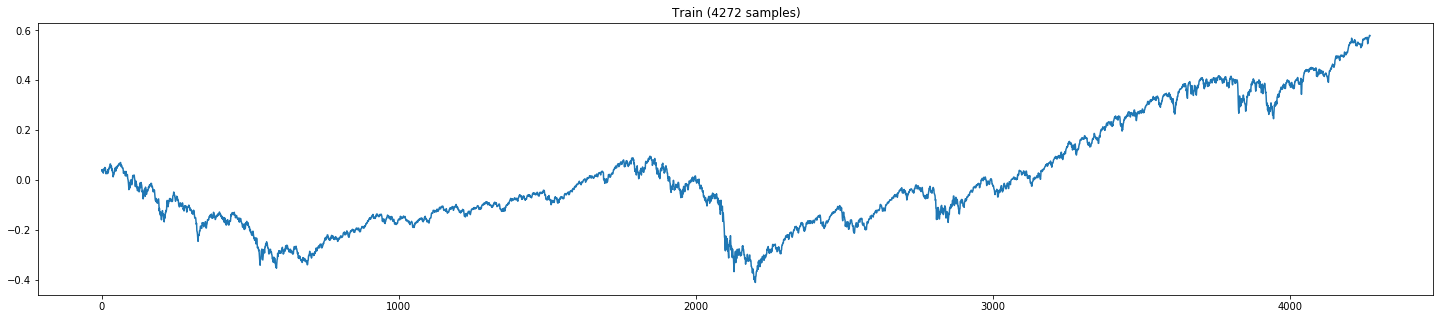

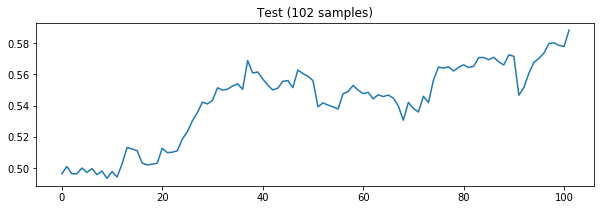

In [14]:
plt.figure(figsize=(25,5))
plt.plot(xTrain)
plt.title('Train (' +str(xTrain.size)+' samples)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest)
plt.title('Test (' +str(xTest.size)+' samples)')
plt.show()

## Placeholder

In [15]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[batch_size,truncated_backprop_length],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[batch_size,truncated_backprop_length],name='target_ph')

init_state = tf.placeholder(dtype=tf.float32,shape=[batch_size,state_size])

## Weights and biases

Because is a 3 layer net:
 1. Input
 2. Hidden Recurrent layer
 3. Output

We need 2 pairs of W and b

In [16]:
W = tf.Variable(initial_value=np.random.rand(state_size+1,state_size),dtype=tf.float32)
b = tf.Variable(initial_value=np.random.rand(1,state_size),dtype=tf.float32)

W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack matrix into 1 dimensional array

In [17]:
inputs_series = tf.unstack(batchX_placeholder,axis=1)
labels_series = tf.unstack(batchY_placeholder,axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [18]:
current_state = init_state
state_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input,[batch_size,1])
    input_and_state_concatenated = tf.concat(axis=1,values=[current_input,current_state])
    
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated,W) + b)
    state_series.append(next_state)
    current_state = next_state
    

## Backward pass - Output

In [19]:
prediction_series = [tf.matmul(state,W2) + b2 for state in state_series]


last_pred = tf.gather(params=prediction_series,indices=len(prediction_series)-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

loss = tf.reduce_mean(tf.squared_difference(last_label, last_pred))

train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss)

In [20]:
loss_list = []
test_pred_list = []

xTrainReshaped = xTrain.reshape((batch_size,-1))
yTrainReshaped = yTrain.reshape((batch_size,-1))

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
        
        #Init hidden state
        _current_state = np.zeros((batch_size,state_size))
        
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = xTrainReshaped[:,start_idx:end_idx]
            batchY = yTrainReshaped[:,start_idx:end_idx]
            
            
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX)
            #print('Y',batchY)
            
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY, init_state : _current_state}
            
            #TRAIN!
            _loss,_train_step,_curr_state,_pred = sess.run(
                fetches=[loss,train_step,current_state,prediction_series],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
            
            if(batch_idx % 400 == 0):
                print('Step %d - Loss: %.2f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(xTest.size - truncated_backprop_length):
        
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length].reshape(batch_size,truncated_backprop_length)
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape(batch_size,truncated_backprop_length)

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY,
            init_state : _current_state}

        #Test_pred contains 'window_size' predictions, we want the last one
        test_pred = sess.run(prediction_series,feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 34.71
Step 400 - Loss: 0.02
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 1
Step 0 - Loss: 0.04
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 2
Step 0 - Loss: 0.11
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 3
Step 0 - Loss: 0.05
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 4
Step 0 - Loss: 0.03
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 5
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 6
Step 0 - Loss: 0.04
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 7
Step 0 - Loss: 0.06
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 8
Step 0 - Loss: 0.08
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 9
Step 0 - Loss: 0.08
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 10
Step 0 - Loss: 0.08
Step 400 - Loss: 0.0

Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 86
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 87
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 88
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 89
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 90
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 91
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 92
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 93
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 94
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 95
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 171
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 172
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 173
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 174
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 175
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 176
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 177
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 178
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 179
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 180
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 256
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 257
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 258
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 259
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 260
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 261
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 262
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 263
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 264
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 265
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 341
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 342
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 343
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 344
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 345
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 346
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 347
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 348
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 349
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 350
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 426
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 427
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 428
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 429
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 430
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 431
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 432
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 433
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 434
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 435
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 511
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 512
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 513
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 514
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 515
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 516
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 517
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 518
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 519
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 520
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 596
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 597
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 598
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 599
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 600
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 601
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 602
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 603
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 604
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 605
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 681
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 682
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 683
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 684
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 685
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 686
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 687
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 688
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 689
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 690
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 766
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 767
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 768
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 769
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 770
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 771
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 772
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 773
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 774
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 775
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 851
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 852
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 853
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 854
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 855
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 856
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 857
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 858
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 859
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 860
Step 0 - Loss: 0.01
Step 400 - Loss: 0.00
Step 800

Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 936
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 937
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 938
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 939
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 940
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 941
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 942
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 943
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 944
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800 - Loss: 0.00
Step 1200 - Loss: 0.00
Epoch 945
Step 0 - Loss: 0.02
Step 400 - Loss: 0.00
Step 800

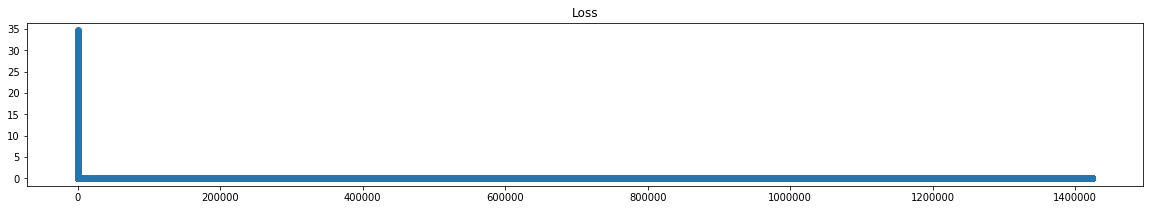

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

## Plot test results

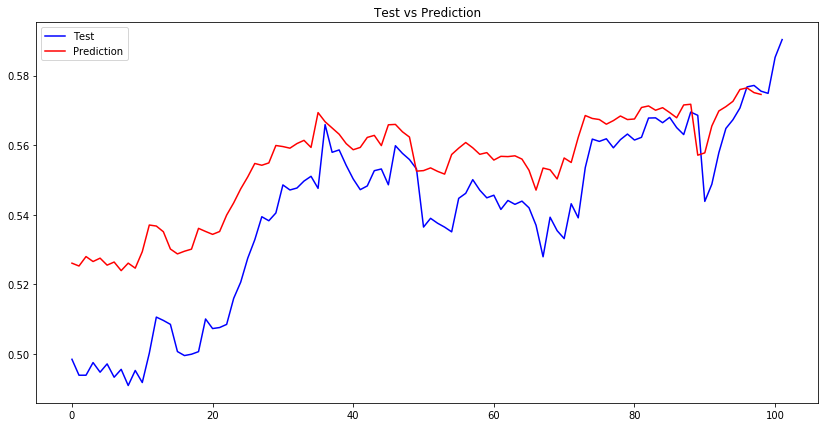

In [24]:
plt.figure(figsize=(14,7))
plt.plot(yTest,label='Test',color='blue')
plt.plot(test_pred_list,label='Prediction',color='red')
plt.title('Test vs Prediction')
plt.legend(loc='upper left')
plt.show()